In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import ruptures as rpt
import numpy as np
from pathlib import Path
from tqdm.notebook import tqdm
from typing import List
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind

In [2]:
def get_cpts(col: pd.Series) -> List[int]:
    signal = np.array(col)
    algo = rpt.Pelt(model="rbf").fit(signal)
    result = algo.predict(pen=len(signal) / 4)
    
    return result

def get_ROC(col_f1: pd.Series, col_f2: pd.Series) -> float:
    start = int(len(col_f1) / 5)
    end = len(col_f1) - start
    return abs((col_f1.iloc[end,] - col_f2.iloc[start,]) / len(col_f1[start:end,]))

def get_tl(col_f1: pd.Series, col_f2: pd.Series) -> float:
    start = int(len(col_f1) / 5)
    end = len(col_f1) - start
    return abs(
        col_f1.iloc[start,] - col_f1.iloc[end,]
    ) + abs(
        col_f2.iloc[start,] - col_f2.iloc[end,]
    )

In [3]:
def make_df_cpts(folder: Path, d: int) -> pd.DataFrame:
    data = []
    for file in Path(f'divided/{folder}/csvs/').iterdir():
        df = pd.read_csv(file)
        f1 = get_cpts(df['f1'])
        f2 = get_cpts(df['f2'])
        data.append({
            'vowel': file.name.rsplit('_', d)[1],
            'cps_1': f1,
            'f1': len(f1),
            'cps_2': f2,
            'f2': len(f2),
            'length': len(df),
            'filename': file.name,
        })
    return pd.DataFrame(data)

In [4]:
def make_df_ROC(folder: Path, d: int) -> pd.DataFrame:
    data = []
    for file in Path(f'divided/{folder}/csvs/').iterdir():
        df = pd.read_csv(file)
        f1 = get_ROC(df['f1'], df['f2'])
        data.append({
            'vowel': file.name.rsplit('_', d)[1],
            'f1': f1
        })
    return pd.DataFrame(data)

In [5]:
def make_df_track_length(folder: Path, d: int) -> pd.DataFrame:
    data = []
    for file in Path(f'divided/{folder}/csvs/').iterdir():
        df = pd.read_csv(file)
        f1 = get_tl(df.f1, df.f2)
        data.append({
            'vowel': file.name.rsplit('_', d)[1],
            'f1': f1
        })
    return pd.DataFrame(data)

In [6]:
def draw_statistics(df: pd.DataFrame, mono: List[str], t: int = 0) -> None:
    
    gr = df.groupby('vowel')
    df[f'mean_1'] = gr['f1'].transform('mean')
    df['sd'] = gr['f1'].transform('std')
    df['n'] = gr['vowel'].transform(len)
    
    sorted_df = df[
        ['vowel', 'mean_1', 'n', 'sd']
    ].groupby('vowel').mean().sort_values('mean_1')
    
    sorted_df[['mean_1', 'sd']] = sorted_df[['mean_1', 'sd']].apply(lambda x: round(x, 2))
    sorted_df['n'] = sorted_df['n'].apply(int)
    
    print(sorted_df)
    plt.figure(figsize=(12, 5))
    sns.violinplot(x = 'vowel', y = "f1", data = df, inner="stick",
                  order=sorted(set(df.vowel), key=lambda x: (len(x.strip('ː')), x)))
    plt.show()
    
    if t == 0:
        t = np.mean(sorted_df.mean_1)
        print(f'Threshold is set to {t}')
    
    
    tp = df[(~df.vowel.isin(mono)) & (df.f1 > t)]
    tn = df[(df.vowel.isin(mono)) & (df.f1 <= t)]
    fp = df[(df.vowel.isin(mono)) & (df.f1 > t)]
    fn = df[(~df.vowel.isin(mono)) & (df.f1 <= t)]
    
    sns.heatmap([[len(tp), len(fp)],
             [len(fn), len(tn)]], annot=True, fmt='.0f',
            xticklabels = ['diphthong', 'monophthong'],
            yticklabels = ['diphthong', 'monophthong']
           )

    plt.xlabel('Real')
    plt.ylabel('Predicted');
    
    specificity = len(tn) / (len(tn) + len(fp))
    recall = len(tp) / (len(tp) + len(fn))

    balanced_accuracy = (specificity + recall) / 2

    print(round(balanced_accuracy, 2),
          round(specificity, 2), 
          round(recall, 2))

## Estonian

In [7]:
df = make_df_cpts('est_liisa', 3)

Overall number of monophthongs is 220
Overall number of diphthongs is 60
       mean_1   n    sd
vowel                  
iː       1.00   6  0.00
æːː      1.00   9  0.00
iːː      1.11  18  0.32
æː       1.14  14  0.36
æ        1.20  60  0.40
eːː      1.29  24  0.46
eː       1.33  12  0.49
i        1.41  39  0.50
e        1.42  38  0.50
æe       1.67   3  0.58
ie       1.83  12  0.39
ea       1.91  45  0.29


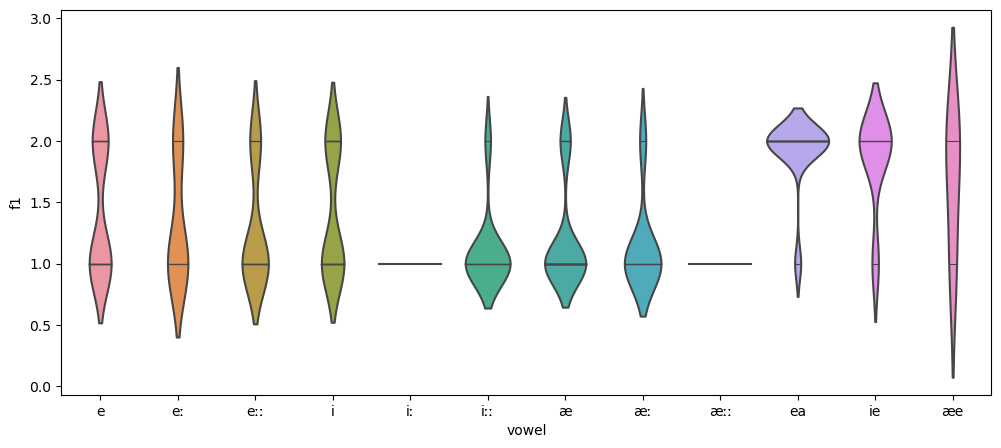

0.81 0.73 0.88


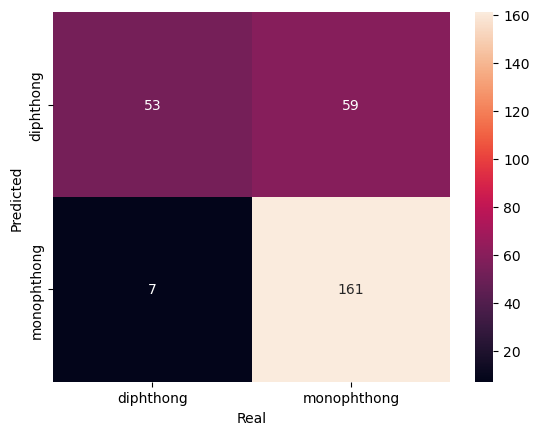

In [8]:
est_mono = ['i', 'iː', 'iːː', 'æ', 'æː', 'æːː', 'e', 'eː', 'eːː']

print(f'Overall number of monophthongs is {sum(df.vowel.isin(est_mono))}\n'\
      f'Overall number of diphthongs is {sum(~df.vowel.isin(est_mono))}')

test = draw_statistics(df, est_mono, 1)

In [9]:
x = df[df.vowel.isin(est_mono)].f1
y = df[~df.vowel.isin(est_mono)].f1

obs = np.array([[sum(x == 1), sum(y == 1)], [sum(x > 1), sum(y > 1)]])
res = chi2_contingency(obs)
res

(71.78977272727272,
 2.3938979770322937e-17,
 1,
 array([[132.,  36.],
        [ 88.,  24.]]))

In [10]:
df = make_df_ROC('est_liisa', 3)

       mean_1   n     sd
vowel                   
æe      11.72   3   0.51
æːː     11.86   9   2.95
æː      19.93  14   7.31
iːː     21.65  18   4.55
iː      22.24   6   2.08
ea      24.12  45   5.22
eː      25.59  12   5.37
eːː     26.20  24   9.48
ie      31.52  12   3.92
æ       43.47  60  24.10
e       57.24  38  14.15
i       97.20  39  31.80


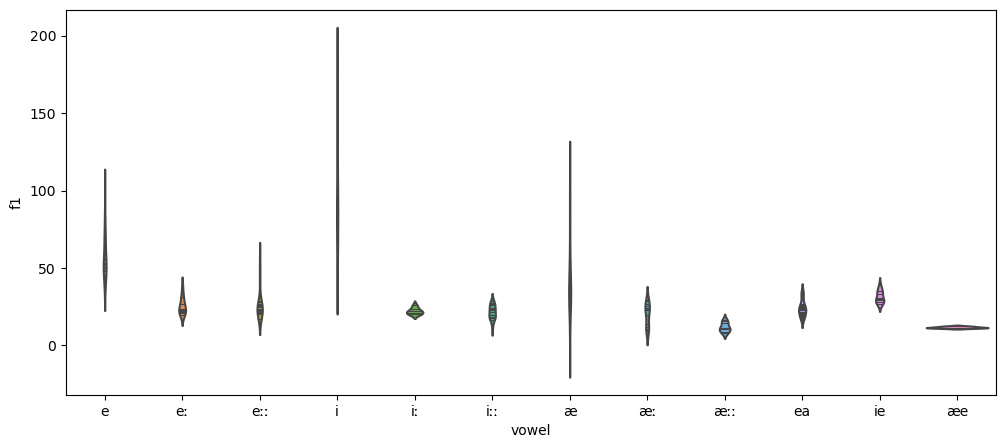

Threshold is set to 32.72833333333333
0.31 0.45 0.17


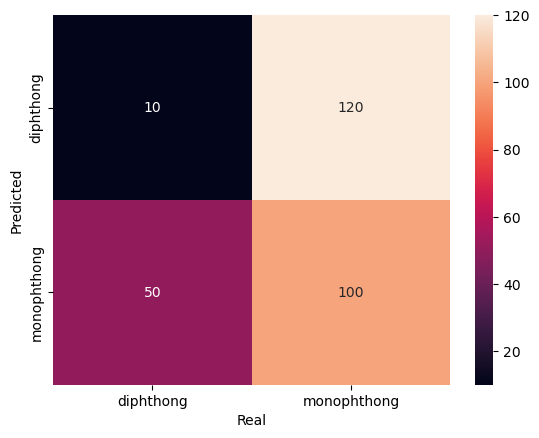

In [11]:
draw_statistics(df, est_mono)

In [12]:
df = make_df_track_length('est_liisa', 3)

        mean_1   n      sd
vowel                     
eː      103.30  12   57.77
æːː     119.17   9   59.05
eːː     121.51  24   71.42
iː      131.78   6   30.04
iːː     137.96  18   70.13
i       146.37  39   77.64
æ       213.10  60  166.38
æː      239.53  14  100.50
e       260.45  38  161.50
æe      303.50   3   52.32
ie      658.08  12  189.68
ea     1065.72  45  179.33


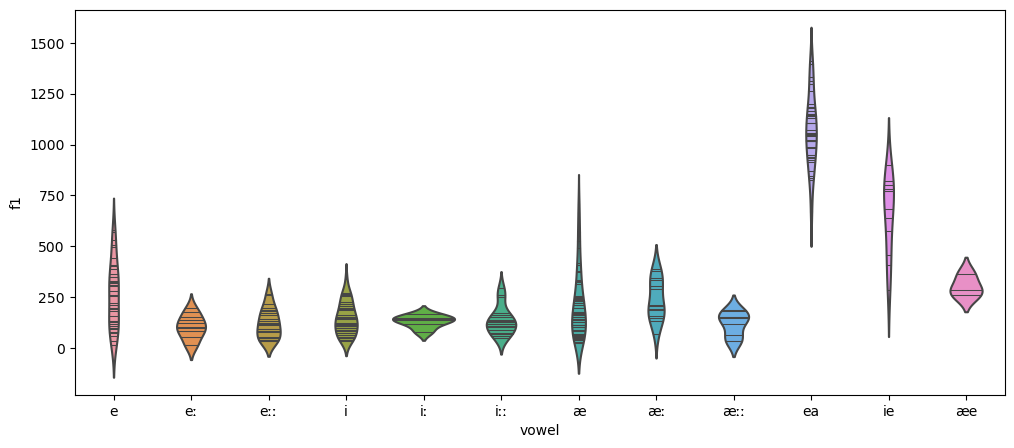

Threshold is set to 291.7058333333334
0.89 0.82 0.95


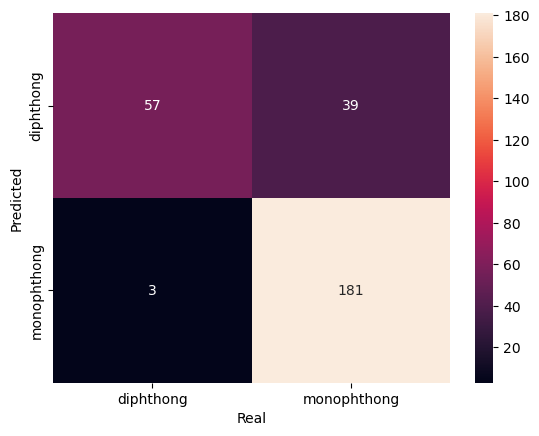

In [13]:
draw_statistics(df, est_mono)

In [14]:
df = make_df_cpts('est_vello', 3)

Overall number of monophthongs is 219
Overall number of diphthongs is 63
       mean_1   n    sd
vowel                  
iː       1.00   6  0.00
æe       1.00   3  0.00
æː       1.00  12  0.00
æːː      1.00   9  0.00
iːː      1.06  18  0.24
eː       1.08  12  0.29
e        1.11  36  0.32
æ        1.16  57  0.37
i        1.36  39  0.49
eːː      1.40  30  0.50
ie       1.71  24  0.46
ea       1.75  36  0.44


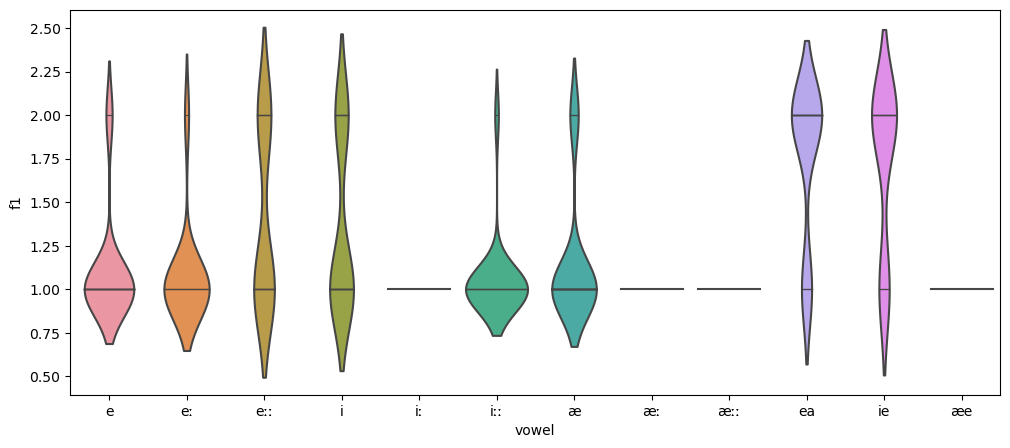

0.76 0.81 0.7


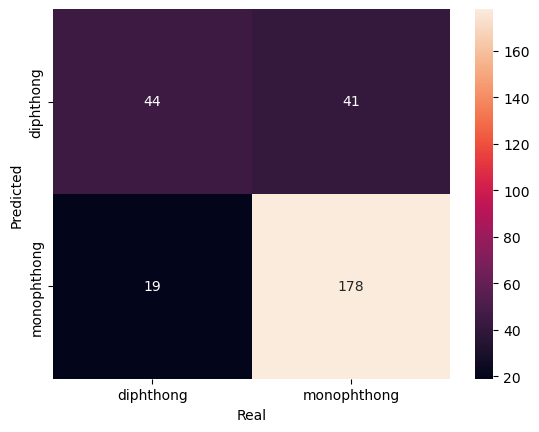

In [15]:
est_mono = ['i', 'iː', 'iːː', 'æ', 'æː', 'æːː', 'e', 'eː', 'eːː']

print(f'Overall number of monophthongs is {sum(df.vowel.isin(est_mono))}\n'\
      f'Overall number of diphthongs is {sum(~df.vowel.isin(est_mono))}')

draw_statistics(df, est_mono, 1)

In [16]:
x = df[df.vowel.isin(est_mono)].f1
y = df[~df.vowel.isin(est_mono)].f1

obs = np.array([[sum(x == 1), sum(y == 1)], [sum(x > 1), sum(y > 1)]])
res = chi2_contingency(obs)
res

(58.31586891901604,
 2.2323613566802255e-14,
 1,
 array([[152.9893617,  44.0106383],
        [ 66.0106383,  18.9893617]]))

In [17]:
df = make_df_ROC('est_vello', 3)

       mean_1   n     sd
vowel                   
æe       8.08   3   0.28
æːː     11.04   9   2.79
æː      12.77  12   2.73
ea      15.98  36   5.78
eːː     17.51  30   2.48
iːː     20.22  18   2.87
eː      24.96  12   4.12
ie      27.17  24   5.02
iː      28.20   6   4.14
æ       33.38  57   9.61
e       40.17  36  12.67
i       66.35  39  33.47


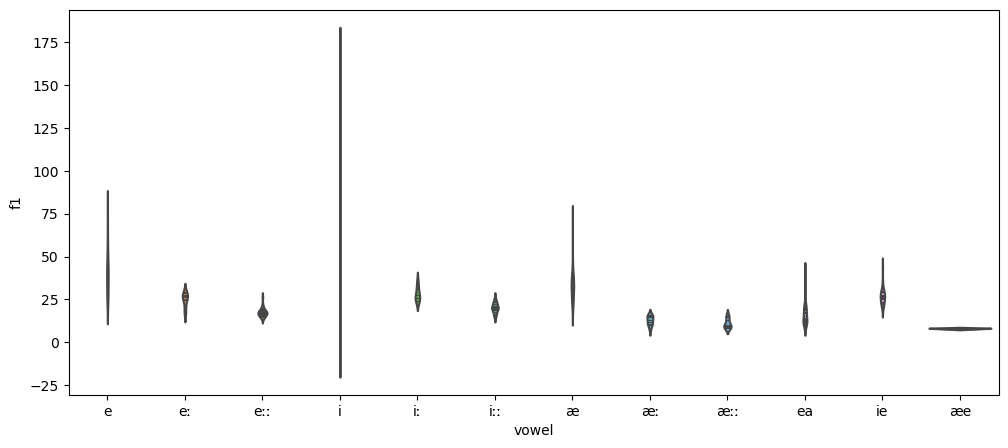

Threshold is set to 25.485833333333336
0.33 0.42 0.25


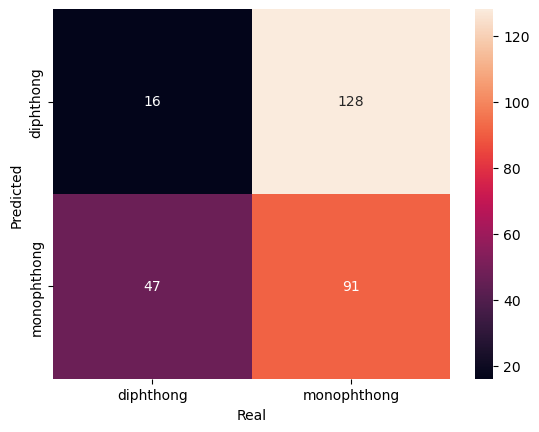

In [18]:
draw_statistics(df, est_mono)

In [19]:
df = make_df_track_length('est_vello', 3)

       mean_1   n      sd
vowel                    
æːː     68.42   9   51.66
æː      68.61  12   35.05
iːː     71.89  18   51.31
æ      109.10  57   57.25
eː     112.46  12   91.47
e      134.96  36   92.82
eːː    139.57  30   94.70
i      219.81  39  170.82
iː     252.73   6  233.70
æe     328.27   3   92.02
ie     414.23  24  130.32
ea     790.86  36  192.70


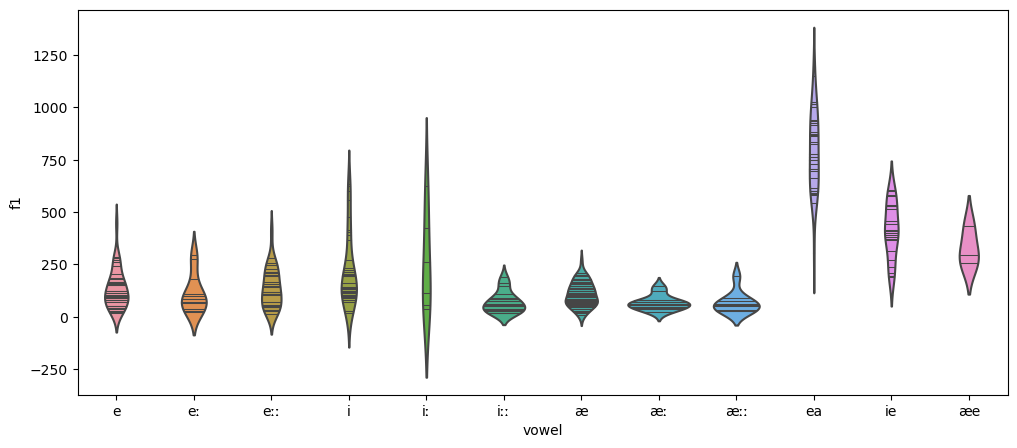

Threshold is set to 225.90916666666666
0.91 0.87 0.95


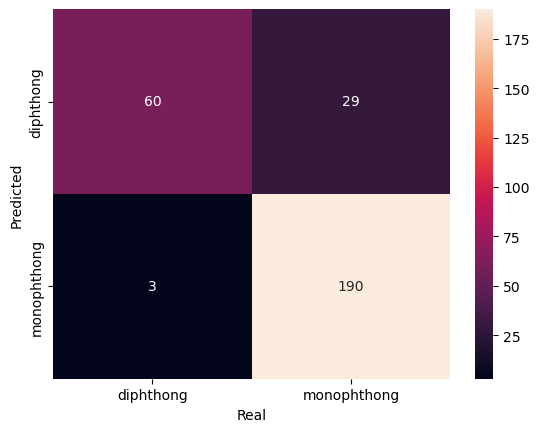

In [20]:
draw_statistics(df, est_mono)

## Lithuanian

In [21]:
df = make_df_cpts('lit', 3)

In [22]:
lit_mono = ['ˈɛː', 'ˈi', 'ˈiː', 'iː', 'i', 'ɛː', 'ˈeː', 'ɛ', 'eː']

print(f'Overall number of monophthongs is {sum(df.vowel.isin(lit_mono))}\n'\
      f'Overall number of diphthongs is {sum(~df.vowel.isin(lit_mono))}')

Overall number of monophthongs is 531
Overall number of diphthongs is 162


In [23]:
x = df[df.vowel.isin(lit_mono)].f1
y = df[~df.vowel.isin(lit_mono)].f1


obs = np.array([[sum(x == 1), sum(y == 1)], [sum(x > 1), sum(y > 1)]])
res = chi2_contingency(obs)
res

(72.29237179644984,
 1.8556330274806572e-17,
 1,
 array([[351.7012987, 107.2987013],
        [179.2987013,  54.7012987]]))

       mean_1    n    sd
vowel                   
ɛː       1.08   24  0.28
ɛ        1.10   21  0.30
ˈɛː      1.16   63  0.37
i        1.19   67  0.40
iː       1.24   63  0.43
ˈiː      1.25  128  0.43
ˈi       1.27   63  0.45
eː       1.42   36  0.50
ˈeː      1.42   66  0.50
iɛ       1.49   51  0.50
ˈiɛ      1.68  111  0.47


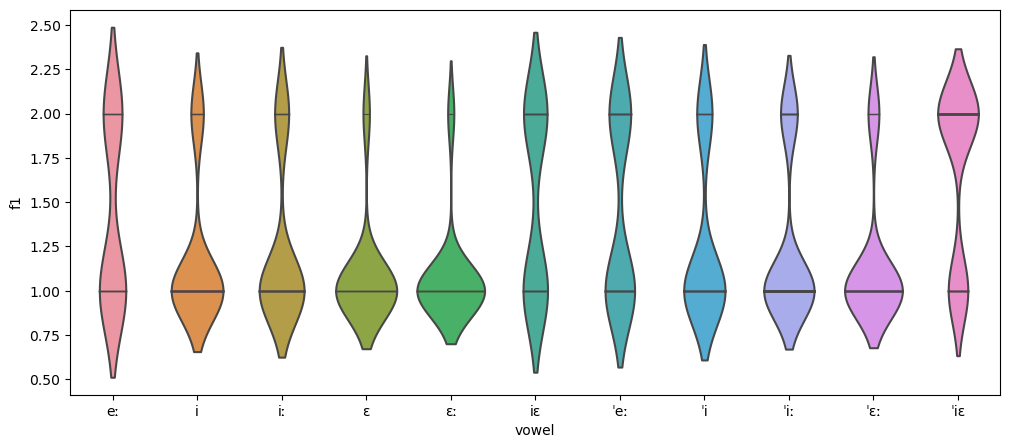

0.68 0.75 0.62


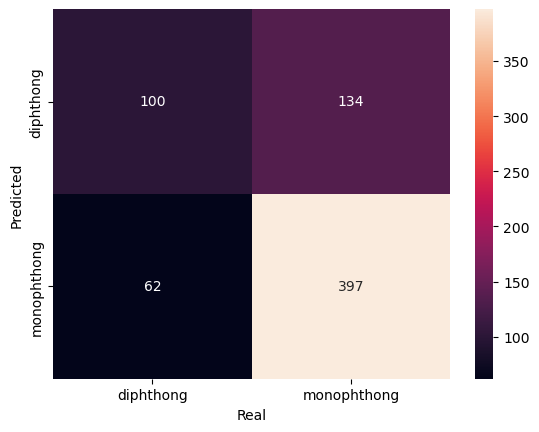

In [24]:
draw_statistics(df, lit_mono, 1)

In [25]:
df = make_df_ROC('lit', 3)

       mean_1    n     sd
vowel                    
ˈɛː     18.78   63   7.31
ˈeː     27.35   66   6.08
ˈiɛ     27.84  111  11.80
ɛː      35.93   24  17.17
eː      38.57   36  16.18
iɛ      38.71   51  16.81
ˈiː     42.96  128  21.27
ɛ       46.40   21  11.80
iː      49.71   63  29.20
ˈi      52.97   63  14.61
i       62.13   67  20.65


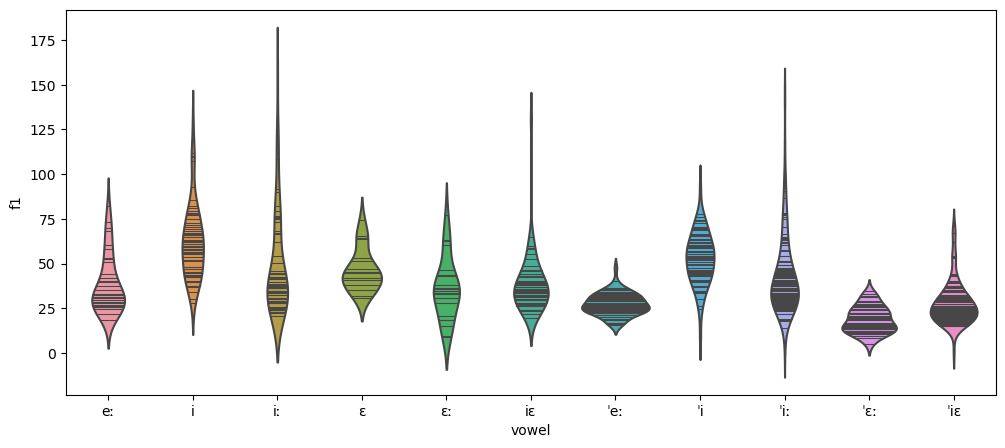

Threshold is set to 40.122727272727275
0.37 0.57 0.17


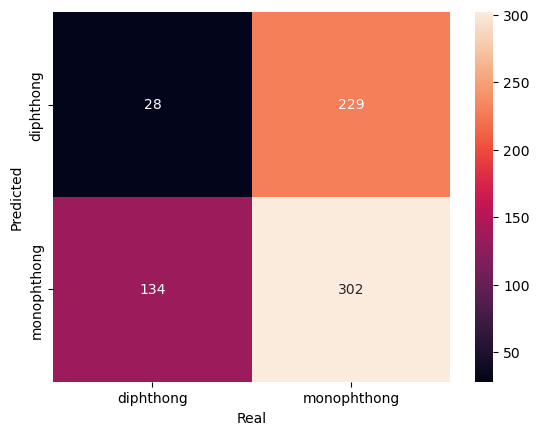

In [26]:
draw_statistics(df, lit_mono)

In [27]:
df = make_df_track_length('lit', 3)

        mean_1    n      sd
vowel                      
ˈiː     200.65  128  230.34
i       233.77   67  294.41
ɛː      239.02   24  108.58
ɛ       250.10   21  149.73
ˈeː     263.35   66  135.21
ˈi      287.69   63  178.89
ˈɛː     349.69   63  202.73
iː      359.22   63  327.49
eː      364.00   36  187.51
iɛ      844.70   51  364.19
ˈiɛ    1068.74  111  444.18


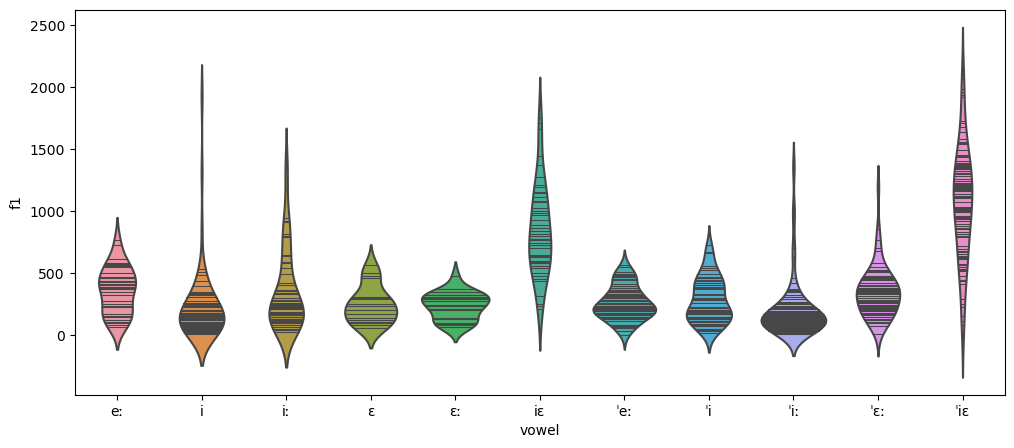

Threshold is set to 405.53909090909093
0.87 0.8 0.93


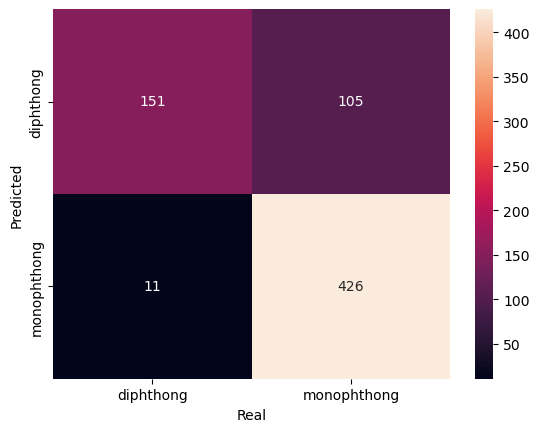

In [28]:
draw_statistics(df, lit_mono)

## Skolt Saami

In [29]:
df = make_df_cpts('skolt', 4)

In [30]:
skolt_mono = ['e', 'eː', 'õ', 'õː', 'â', 'âː', 'i', 'iː']

print(f'Overall number of monophthongs is {sum(df.vowel.isin(skolt_mono))}\n'\
      f'Overall number of diphthongs is {sum(~df.vowel.isin(skolt_mono))}')

Overall number of monophthongs is 82
Overall number of diphthongs is 47


In [31]:
x = df[df.vowel.isin(skolt_mono)].f1
y = df[~df.vowel.isin(skolt_mono)].f1

obs = np.array([[sum(x == 1), sum(y == 1)], [sum(x > 1), sum(y > 1)]])
res = chi2_contingency(obs)
res

(40.39427972951222,
 2.0754787118048087e-10,
 1,
 array([[54.03100775, 30.96899225],
        [27.96899225, 16.03100775]]))

       mean_1   n    sd
vowel                  
õː       1.00   3  0.00
õ        1.04  26  0.20
âː       1.08  12  0.29
eː       1.14  14  0.36
â        1.17   6  0.41
e        1.29  21  0.46
eä       1.66  32  0.48
iä       1.67   6  0.52
ie       1.83   6  0.41
iõ       2.00   3  0.00


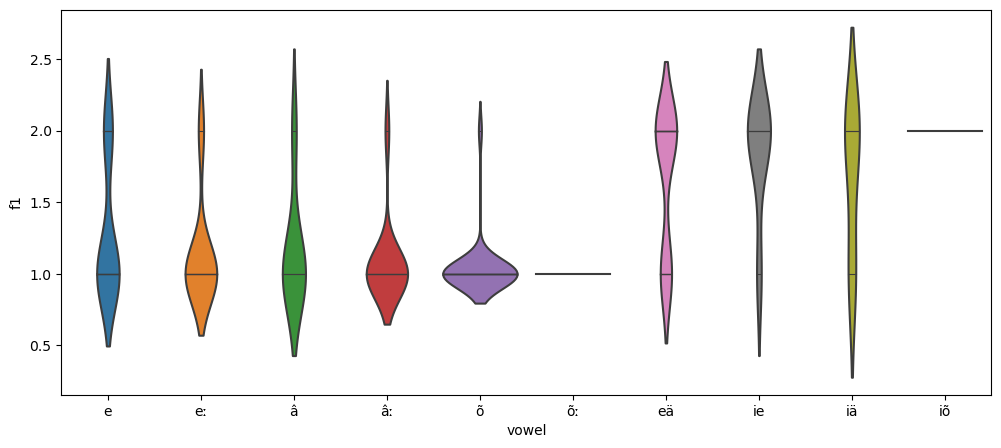

0.78 0.87 0.7


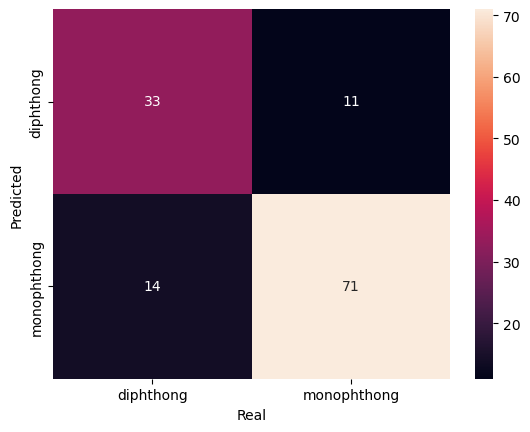

In [32]:
draw_statistics(df, skolt_mono, 1)

In [33]:
df = make_df_track_length('skolt', 4)

       mean_1   n      sd
vowel                    
õː     219.43   3  110.12
õ      299.85  26  276.54
eː     333.06  14  240.01
e      365.21  21  294.30
âː     449.59  12  191.90
â      491.45   6  308.23
eä     785.61  32  582.19
iä     809.45   6  370.37
iõ     869.90   3  101.16
ie     962.73   6  283.82


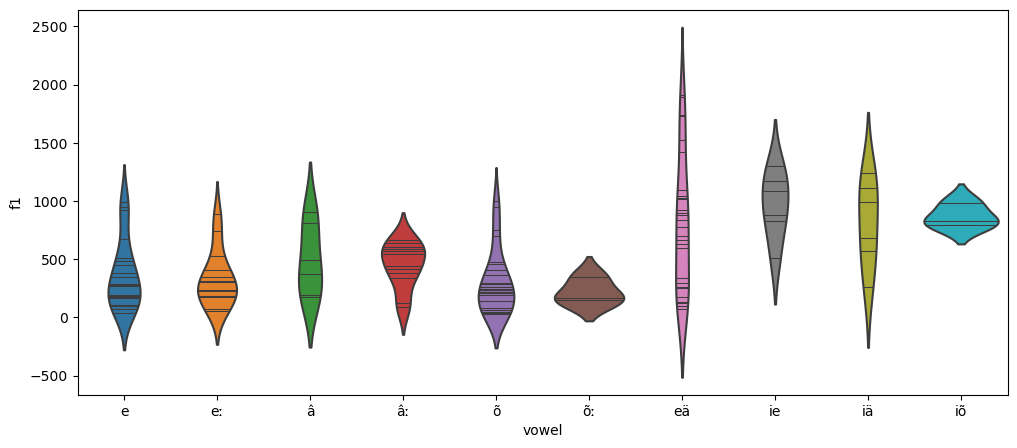

Threshold is set to 558.6279999999999
0.75 0.79 0.7


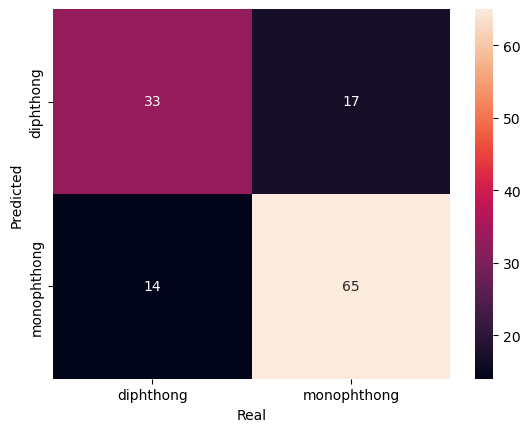

In [34]:
draw_statistics(df, skolt_mono)

## Kildin Saami

In [35]:
df = make_df_cpts('kld', 3)

In [36]:
kld_mono = ['e', 'iː', 'aː', 'eː']

print(f'Overall number of monophthongs is {sum(df.vowel.isin(kld_mono))}\n'\
      f'Overall number of diphthongs is {sum(~df.vowel.isin(kld_mono))}')

Overall number of monophthongs is 149
Overall number of diphthongs is 120


In [37]:
x = df[df.vowel.isin(kld_mono)].f1
y = df[~df.vowel.isin(kld_mono)].f1

obs = np.array([[sum(x == 1), sum(y == 1)], [sum(x > 1), sum(y > 1)]])
res = chi2_contingency(obs)
res

(1.93514077313131,
 0.16419711411550453,
 1,
 array([[99.14869888, 79.85130112],
        [49.85130112, 40.14869888]]))

       mean_1   n    sd
vowel                  
aː       1.25  77  0.43
ea       1.25  28  0.44
eː       1.34  32  0.48
iː       1.35  40  0.48
ie       1.42  92  0.50


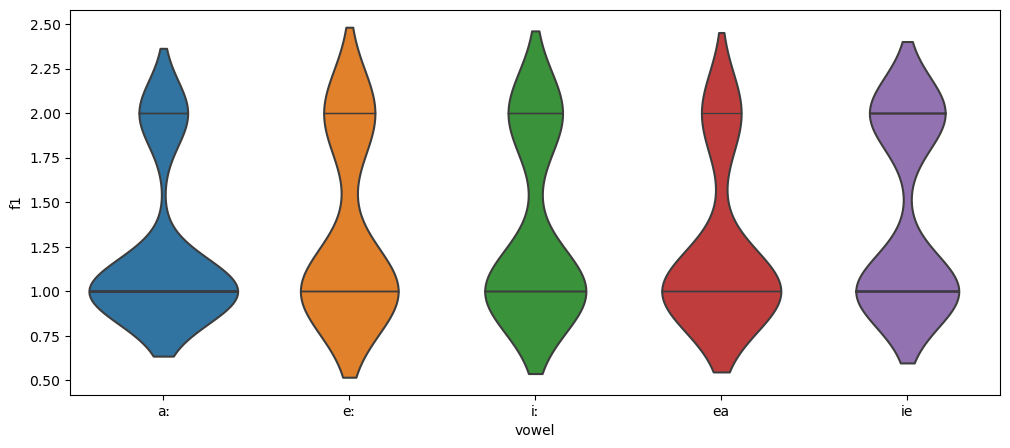

0.54 0.7 0.38


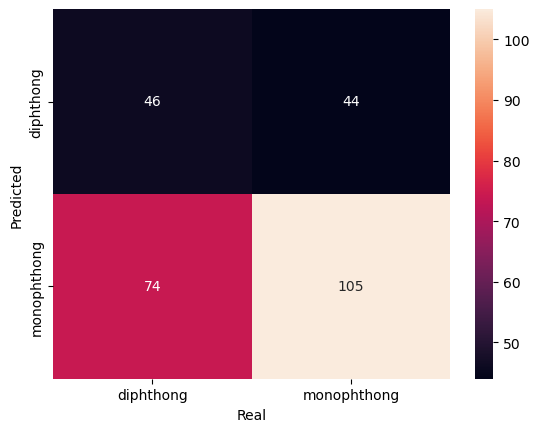

In [38]:
draw_statistics(df, kld_mono, 1)

In [39]:
df = make_df_track_length('kld', 3)

       mean_1   n      sd
vowel                    
iː     127.25  40  159.11
eː     198.92  32  133.62
ie     295.95  92  266.88
aː     299.34  77  210.82
ea     516.21  28  362.23


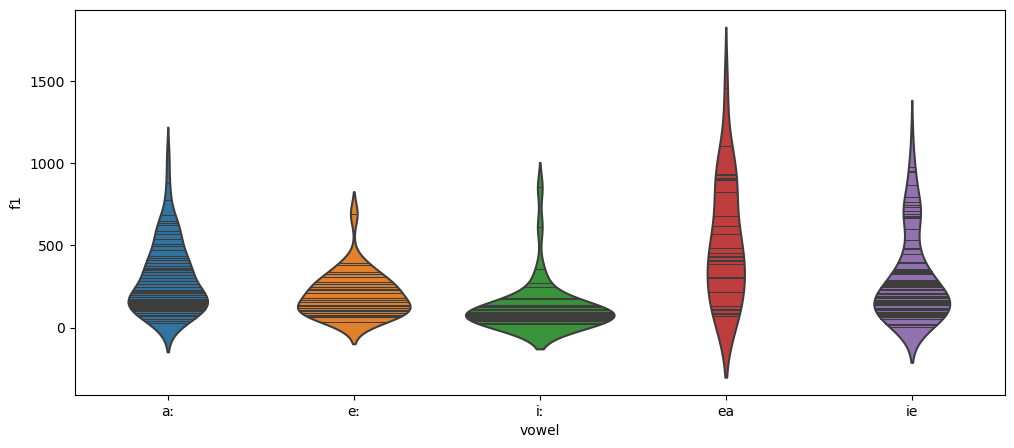

Threshold is set to 287.534
0.57 0.72 0.42


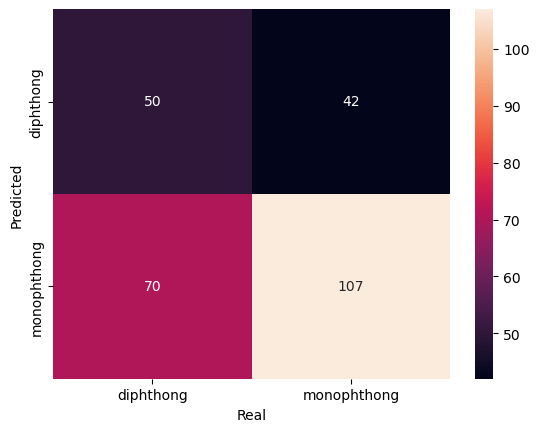

In [40]:
draw_statistics(df, kld_mono)

# Russian

In [41]:
df = make_df_cpts('rus', 3)

In [42]:
rus_mono = ['e', 'ɨ', 'a', 'o', 'u', 'i']

print(f'Overall number of monophthongs is {sum(df.vowel.isin(rus_mono))}\n'\
      f'Overall number of diphthongs is {sum(~df.vowel.isin(rus_mono))}')

Overall number of monophthongs is 107
Overall number of diphthongs is 109


In [43]:
x = df[df.vowel.isin(rus_mono)].f1
y = df[~df.vowel.isin(rus_mono)].f1

obs = np.array([[sum(x == 1), sum(y == 1)], [sum(x > 1), sum(y > 1)]])
res = chi2_contingency(obs)
res

(10.279281531698674,
 0.0013453232300408352,
 1,
 array([[75.79166667, 77.20833333],
        [31.20833333, 31.79166667]]))

       mean_1   n    sd
vowel                  
ɨ        1.00   6  0.00
u        1.06  18  0.24
a        1.11  27  0.32
i        1.20  20  0.41
ju       1.27  22  0.46
ja       1.28  29  0.45
e        1.33   9  0.50
o        1.33  27  0.48
jo       1.45  29  0.51
je       1.55  29  0.51


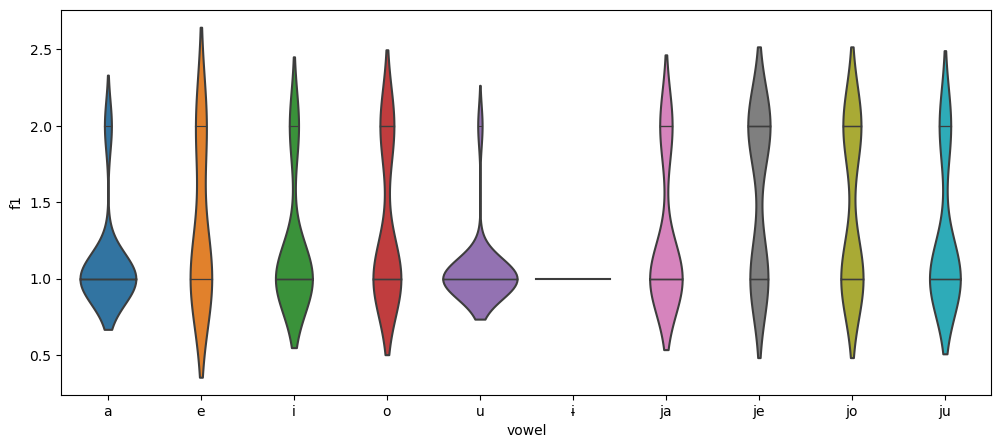

0.6 0.81 0.39


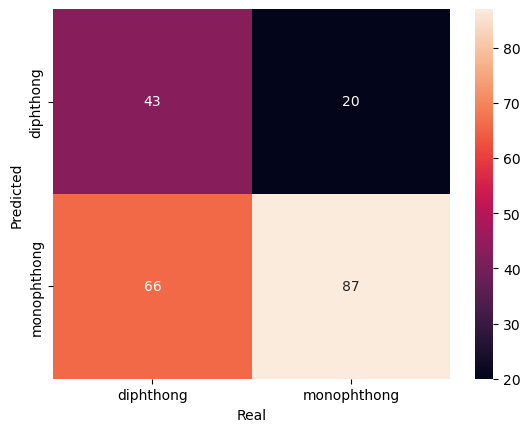

In [44]:
draw_statistics(df, rus_mono, 1)

In [45]:
df = make_df_track_length('rus', 3)

       mean_1   n      sd
vowel                    
ɨ      208.40   6   57.88
u      243.06  18  145.92
e      256.84   9  139.58
i      256.91  20  320.69
o      271.31  27  145.18
a      324.24  27  195.20
je     472.81  29  337.66
ju     582.11  22  345.72
ja     584.07  29  361.46
jo     649.45  29  289.74


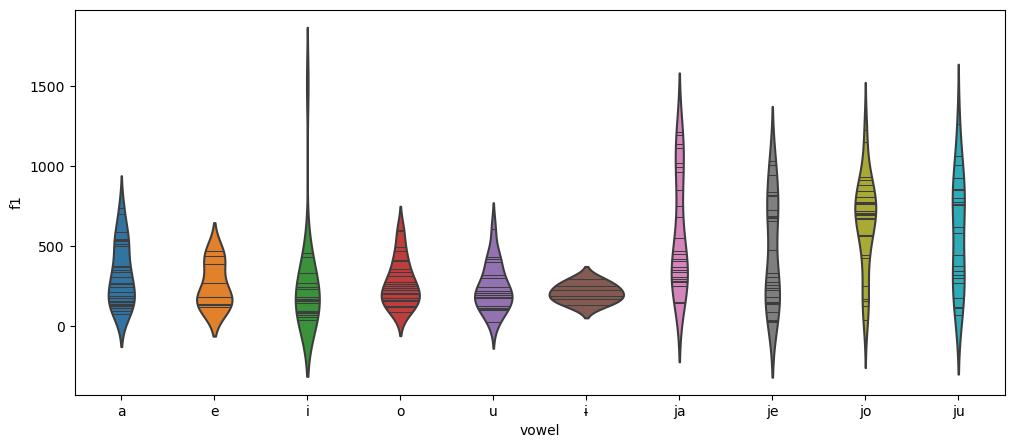

Threshold is set to 384.91999999999996
0.7 0.78 0.61


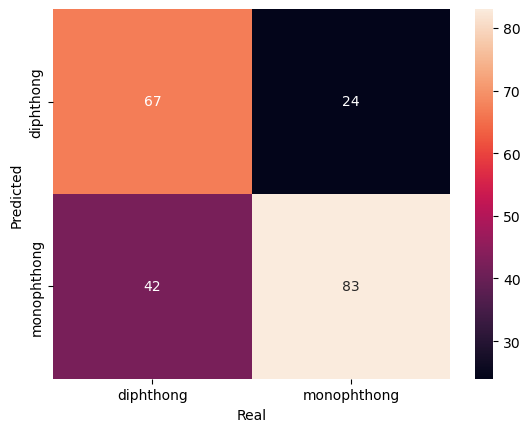

In [46]:
draw_statistics(df, rus_mono)